In [1]:
using PyPlot, LinearAlgebra, TestImages
eye(n) = Matrix(I, n, n)

eye (generic function with 1 method)

In [2]:
# Low-rank approximation with SVD
function LowRankApprox(U, s, V; rank=1)
    Ur, sr, Vr = U[:, 1:rank], s[1:rank], V[:, 1:rank]
    return Ur * diagm(sr) * Vr'
end;

In [3]:
img = convert(Array{Float64}, testimage("cameraman"));
U, s, V = svd(img); # PythonとJuliaでVに転置がかかっているか否かの違いあり．
ranklist = [1, 25, 50]
nr = length(ranklist)
img_approx = [LowRankApprox(U, s, V, rank=r) for r in ranklist];

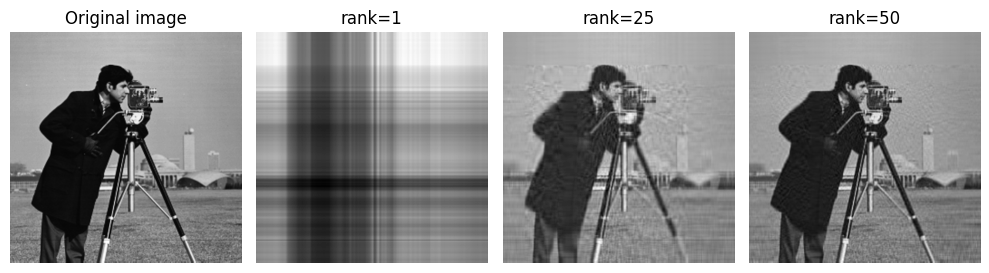

In [4]:
figure(figsize=(10, 3))
subplot(1, nr+1, 1); imshow(img, cmap="gray"); title("Original image"); axis("off")
for i in 1:nr
    subplot(1, nr+1, i+1); imshow(img_approx[i], cmap="gray"); title("rank="*string(ranklist[i])); axis("off")
end
tight_layout()

In [5]:
# Set initial values
N1, N2, N3 = 4, 16, 7
Σyx = [ones(4)'; ones(2)' zeros(2)'; zeros(2)' ones(2)'; eye(4)];
Σx = eye(N1)
u, s, v = svd(Σyx);
eps = 1e-2
W1, W2 = eps*rand(N2,N1), eps*rand(N3,N2) # weight for deep
Ws = eps*rand(N3,N1) # weight for shallow

#Simulation & training
dt = 0.005
Nt = 1500
A, B = zeros(Nt, N1), zeros(Nt, N1); # Singular values for deep, shallow

In [6]:
# Shallow network
for t in 1:Nt
    # Update weights
    Ws += (Σyx - Ws * Σx) * dt   
    # SVD & save results
    Σ̂yx = Ws * Σx
    _, a, _ = svd(Σ̂yx)
    B[t, :] += a
end

In [7]:
# Deep network
for t in 1:Nt
    # Update weights
    δ = Σyx - W2 * W1 * Σx
    W1 += (W2' * δ) * dt
    W2 += (δ * W1') * dt
    # SVD & save results
    Σ̂yx = W2 * W1 * Σx
    _, a, _ = svd(Σ̂yx)
    A[t, :] += a
end

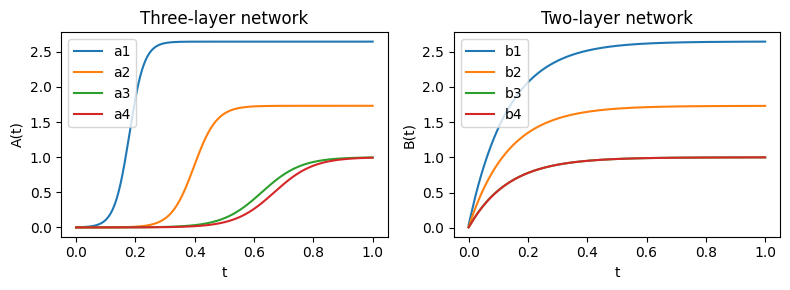

In [8]:
# Plot results
T = range(0, 1, length=Nt)
figure(figsize=(8,3))
subplot(1,2,1); title("Three-layer network")
plot(T, A[:,1], label="a1"); plot(T, A[:,2], label="a2"); 
plot(T, A[:,3], label="a3"); plot(T, A[:,4], label="a4")
xlabel("t"); ylabel("A(t)"); legend()
subplot(1,2,2); title("Two-layer network")
plot(T, B[:,1], label="b1"); plot(T, B[:,2], label="b2"); 
plot(T, B[:,3], label="b3"); plot(T, B[:,4], label="b4")
xlabel("t"); ylabel("B(t)"); legend()
tight_layout()